In [1]:
%matplotlib notebook
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time

In [4]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'

f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --max-nbl 3")
values = craco.search_pipeline.get_parser().parse_args([])
print(values)

parsing values --ndm 2 --max-nbl 3
Upper registers [(37, 6), (37, 7), (38, 7), (38, 8), (39, 8), (39, 9), (40, 9), (40, 10), (40, 11), (41, 11), (102, 11), (41, 12), (42, 12), (102, 12), (42, 13), (43, 13), (102, 13), (43, 14), (102, 14), (103, 14), (18, 15), (43, 15), (44, 15), (103, 15), (18, 16), (19, 16), (44, 16), (45, 16), (103, 16), (19, 17), (20, 17), (45, 17)]
Lower registers [(26, 47), (26, 48), (27, 48), (27, 49), (28, 49), (28, 50), (29, 50), (30, 51), (31, 51), (31, 52), (32, 52), (32, 53), (33, 53), (33, 54), (34, 54), (35, 54), (35, 55), (36, 55), (53, 55), (54, 55), (6, 56), (36, 56), (37, 56), (54, 56), (55, 56), (7, 57), (8, 57), (37, 57), (38, 57), (55, 57), (56, 57), (8, 58)]
Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, injection_file=None, input_scale=1.0, nbloc

In [5]:
from craft.craco_kernels import FdmtGridder, Imager
gridder = FdmtGridder(None, plan, values)

In [6]:
def image_fft(g, scale='none'):
    '''
    Do the complex-to-complex imaging FFT with the correct shifts and correct inverse thingy
    If g.shape = (Npix, Npix) then we assume the center of the UV plane is at
    Npix/2, Npix/2 = DC
    Noramlised by np.prod(img.shape) - which I think is the same as the Xilinx FFT
    
    :scale: 'none' or None for raw FFT output. 'prod' for np.prod(g.shape)

    '''
    # The old version was incorrect!
    #cimg = np.fft.fftshift(np.fft.ifft2(g)).astype(np.complex64)

    if scale == 'none':
        s = 1.0
    elif scale == 'prod':
        s = np.prod(g.shape)
    
    cimg = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g)))/s
    return cimg


In [13]:
din = np.zeros((659, 256, 186, 8), dtype=np.complex64)
din[:].real = 1

In [14]:
grid = gridder( 0, 0,din)

<IPython.core.display.Javascript object>


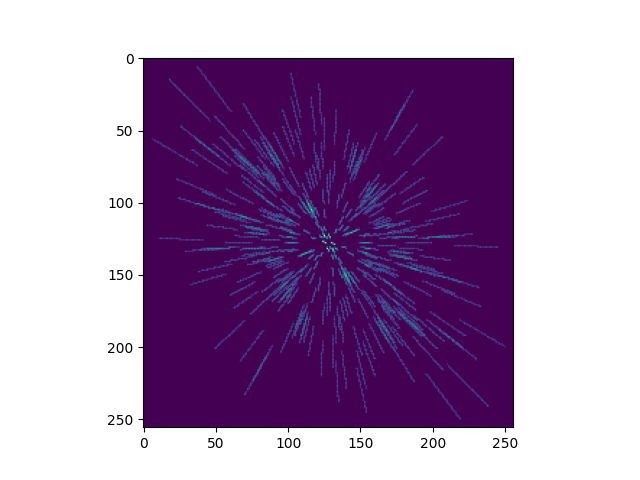

In [15]:
figure()
imshow(grid.real)

<IPython.core.display.Javascript object>


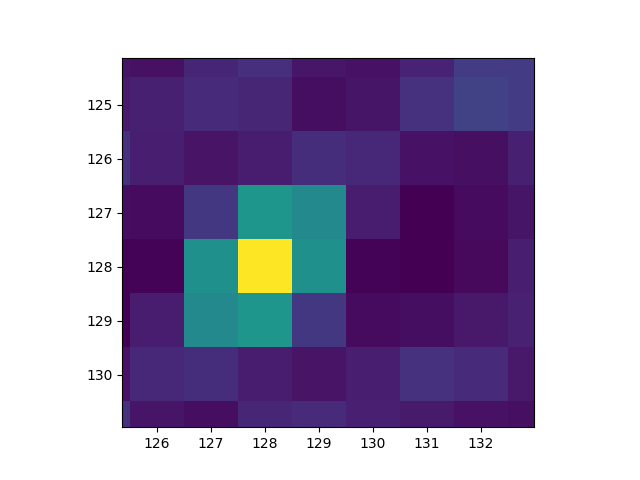

In [19]:
img = image_fft(grid)
figure()
imshow(img.real)

In [29]:
plan.nbl*plan.nf

48640

In [31]:
grid.sum()

(10490+10490j)